In [2]:
import sys
sys.path.append('../../')
import numpy as np
import collections
import os
from utils import utils
import scipy.stats as ss
import pandas as pd
import json



SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            #chrom = rsid.split("_")[0][3:]
            chrom = int(arr[1])
            pos   = int(arr[2])
            p     = float(arr[7])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[3])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res   

def find_annotated(res_dict, dhs_file, isannotated=False):
    dhs = open(dhs_file)
    line = dhs.readline()
    prev_chrm = 0
    nannot = 0
    nannot_type = collections.defaultdict(int)

    sorted_res_dict = dict()
    for chrm in range(1,23):
        sorted_res_dict[chrm] = sorted(res_dict[chrm])
    while line:
        arr = line.rstrip().split()
        if arr[0][3:] == "X" or arr[0][3:] == "Y":
            line = dhs.readline()
            continue
        chrm = int(arr[0][3:])
        start = int(arr[1])
        end = int(arr[2])
        if isannotated:
            atype = arr[9]
        if chrm != prev_chrm:
            remaining = sorted_res_dict[chrm]
            checked = 0
        if len(remaining) == 0:
            ## No more SNPs in this chromosome, just continue reading the DHS file
            line = dhs.readline()
        else:
            for pos in remaining:
                if pos < start:
                    checked += 1
                    remaining = sorted_res_dict[chrm][checked:]
                    continue # go to next SNP
                elif pos > end:
                    line = dhs.readline()
                    break # go to next DHS line, keep checking the remaining results
                else:
                    # this is an annotated SNP
                    checked += 1
                    remaining = sorted_res_dict[chrm][checked:]
                    nannot += 1
                    if isannotated:
                        nannot_type[atype] += 1
                    continue # go to next SNP
        prev_chrm = chrm
    dhs.close()
    return nannot, nannot_type

def sample_random_fst(snps_list, gtex_fst_bins, fst_distrib):
    hist_range=(0,1)
    bin_w=0.05
    nbins = int(max(hist_range)/bin_w)

    target_distrib_counts, bins = np.histogram(np.array(fst_distrib)[~np.isnan(fst_distrib)], bins=nbins, range=hist_range)
    # print(target_distrib_counts, bins)

    res_list = list()
    res_dict = dict()
    for chrm in np.arange(1, 23):
        res_dict[chrm] = list()

    for i,c in enumerate(target_distrib_counts):
        curr_bin = np.around(bins[i],2)
        if c <= 0:
            continue
        if curr_bin not in gtex_fst_bins:
            print(f"Problem! {curr_bin} not in gtex_fst_bins")
            raise
        if c > len(gtex_fst_bins[curr_bin]):
            print("Error, c cannot be larger than available snps in that bin")
            raise
        # print(f"sample {c} from {len(gtex_fst_bins[curr_bin])}")
        chooseidx = np.sort(np.random.choice(len(gtex_fst_bins[curr_bin]), c, replace = False))
        for idx in chooseidx:
            var_id = gtex_fst_bins[curr_bin][idx]
            info = var_id.split('_')
            chrm = int(info[0][3:])
            bppos = int(info[1])
            res_dict[chrm].append(bppos)
            res_list.append(var_id)
    return res_dict, res_list

def annotated_random_fst(snps_list, gtex_fst_bins, target_distrib, dhs_file):
    res_dict, res_list = sample_random_fst(snps_list, gtex_fst_bins, target_distrib)
    nannot, _nannot_type = find_annotated(res_dict, dhs_file)
    return nannot

def sample_rand_bg(snps_list, dhs_file, gtex_fst_bins, target_distrib, niter = 20):
    nannot_rand = list()
    print(f'Iteration', end="")
    for k in range(niter):
        nannot_k = annotated_random_fst(snps_list, gtex_fst_bins, target_distrib, dhs_file)
        print(f' {k}', end="")
        # print(f'Iteration {k}: {nannot_k}')
        nannot_rand.append(nannot_k)
    print("")
    print(np.mean(nannot_rand), len(target_distrib))
    frac_rand = np.mean(nannot_rand) / len(target_distrib)
    print(frac_rand)
    return frac_rand

def read_fst_file(infile):
    fst_dict = dict()
    for i in range(1,23):
        fst_dict[i] = dict()
        with open(infile.format(i)) as instream:
            next(instream)
            for line in instream:
                arr = line.strip().split("\t")
                if line.strip() == "":
                    continue
                fst_dict[int(arr[0])][int(arr[1])] = float(arr[2])
    return fst_dict


In [3]:

### Load tissues and metadata
tissue_file = "../../plots/tissue_table.txt"
json_file   = "../../gtex_v8_metadata.json"
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_nsamples = dict()

for tshort, tfull, tstring in zip(tshorts, tfulls, tstrings):
    if tshort in tshorts:
        tissue_names[tshort] = tstring
        tissue_colors[tshort] = "#" + gtex_meta[tfull]["colorHex"]
        tissue_nsamples[tshort] = gtex_meta[tfull]["rnaSeqSampleCount"]
        
brain_tissues = ['bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu']
altsb_tissues = ['haa', 'pan', 'spl', 'wb']

In [4]:
title    = "multi_tissue"
dhs_file = "/cbscratch/franco/datasets/multi-tissue.master.ntypes.simple.hg19_hglift_hg38_clean.bed"

master_snp_data_file = "/cbscratch/franco/datasets/gtex_v8_dhs_{:s}_background_SHAPEIT2_Fst_matched_DEBUG.txt".format(title)

all_snp_ids = pd.read_csv(os.path.join("/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas.txt"), usecols=[0], header=0, sep="\t")
snps_list = list(all_snp_ids.values.reshape(-1))

fst_file_gtex = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/GTEx_v8_SHAPEIT2_EUR-AFR-OTH-chr{:d}.weir.fst"
fst_gtex = read_fst_file(fst_file_gtex)

In [5]:
# Load Fst dict for gtex
gtex_fst_dict = dict()
with open("../fst_analysis/gtex_3pop_fsts.txt") as instream:
    for line in instream:
        arr = line.strip().split()
        fst = float(arr[1])
        gtex_fst_dict[arr[0]] = fst if fst >= 0.0 else 0.0

with open("../fst_analysis/gtex_fst_bins_3pop.json") as instream:
    gtex_fst_bins_tmp = json.load(instream)
gtex_fst_bins = dict()
# remap keys to floats
for k in gtex_fst_bins_tmp:
    gtex_fst_bins[float(k)] = gtex_fst_bins_tmp[k]

#convert this chrm,pos dict into varid->fst value
gtex_varid_fst = dict()
for varid in snps_list:
    chrom = int(varid.split("_")[0][3:])
    pos   = int(varid.split("_")[1])
    gtex_varid_fst[varid] = fst_gtex[chrom][pos]

# Load trans-eqtl results
basename = "protein_coding_lncRNA_{:s}_knn30_cut5e-8"
gammas = ["gamma01", "gamma0006"]
basepath = "/cbscratch/franco/trans-eqtl"


In [6]:
trans_dict = dict()
for tissue in tshorts:
    if tissue in altsb_tissues:
        config = basename.format(gammas[1])
    else:
        config = basename.format(gammas[0])
    tejaas_file = os.path.join(basepath, config, tissue, "trans_eqtls_ldpruned.txt")

    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    print("Loading ", tissue, end="")
    transeqtls = tejaas(tejaas_file)
    if len(transeqtls) > 0:
        trans_dict[tissue] = transeqtls
        print(" has {:d} trans-eqtls".format(len(transeqtls)))
    else:
        trans_dict[tissue] = []
        print(" has 0 trans-eqtls")


Loading  as has 586 trans-eqtls
Loading  av has 463 trans-eqtls
Loading  ag has 184 trans-eqtls
Loading  aa has 1298 trans-eqtls
Loading  ac has 1539 trans-eqtls
Loading  at has 391 trans-eqtls
Loading  bam has 1182 trans-eqtls
Loading  ban has 954 trans-eqtls
Loading  bca has 19 trans-eqtls
Loading  bceh has 128 trans-eqtls
Loading  bce has 40 trans-eqtls
Loading  bco has 64 trans-eqtls
Loading  bfr has 32 trans-eqtls
Loading  bhi has 51 trans-eqtls
Loading  bhy has 83 trans-eqtls
Loading  bnu has 379 trans-eqtls
Loading  bpu has 10 trans-eqtls
Loading  bsp has 61 trans-eqtls
Loading  bsu has 28 trans-eqtls
Loading  br has 505 trans-eqtls
Loading  ebv has 297 trans-eqtls
Loading  fib has 209 trans-eqtls
Loading  cols has 75 trans-eqtls
Loading  colt has 1174 trans-eqtls
Loading  esog has 17 trans-eqtls
Loading  esom has 9 trans-eqtls
Loading  esomu has 20 trans-eqtls
Loading  haa has 64 trans-eqtls
Loading  hlv has 247 trans-eqtls
Loading  kc has 14 trans-eqtls
Loading  liv has 37 tra

In [7]:
tissue="as"
tissue_target_distrib = [gtex_fst_dict[x.rsid] for x in trans_dict[tissue]]
print(len(tissue_target_distrib))
dhs_frac_rand = sample_rand_bg(snps_list, dhs_file, gtex_fst_bins, tissue_target_distrib, niter = 1)
print (f'Fraction of annotated SNPs: {tissue} - {dhs_frac_rand:7.4f}')

586
Iteration 0
78.0 586
0.13310580204778158
Fraction of annotated SNPs: as -  0.1331


In [11]:
res_dict, res_list = sample_random_fst(snps_list, gtex_fst_bins, tissue_target_distrib)
rand_distrib = [gtex_fst_dict[x] for x in res_list]

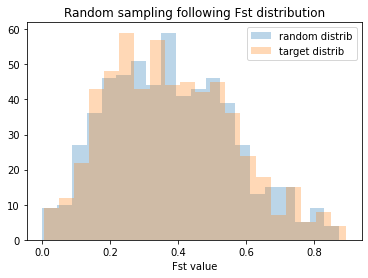

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(rand_distrib, bins=20, label="random distrib", alpha=0.3)
ax1.hist(tissue_target_distrib, bins=20, label="target distrib", alpha=0.3)
ax1.set_xlabel("Fst value")
ax1.set_title("Random sampling following Fst distribution")
ax1.legend()
plt.show()

In [ ]:
# print("Creating snp_data file")
# with open(master_snp_data_file, 'w') as ofile:
#     ofile.write("tissue\ttype\tn_snps\tdhs_frac_rand\n")
#     ofile.write(f"{tissue}\tall\t-\t{dhs_frac_rand}\n")